In [14]:
%load_ext autoreload
%autoreload 2

from wfa.ml_logic.model import predict_new_images 
from wfa.utils.image_viz import plot_classified_images, plot_sub_images_categories, plot_image_categories
from wfa.utils.get_new_images import get_new_image, split_tiles
from wfa.ml_logic import registry

import numpy as np

import os
from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
adr = '45.2252929,5.6858077'
#adr = 'Shanghai'
year1 = '2018' 
year2 = '2020'

new_img1 = get_new_image(adr, year1)
new_img2 = get_new_image(adr, year2)

X_test1 = split_tiles(new_img1)
X_test2 = split_tiles(new_img2)

new_model = registry.load_model()

cat_pred1 = predict_new_images(new_model, X_test1);
cat_pred2 = predict_new_images(new_model, X_test2);


Load model Production stage from mlflow...


2022-12-12 12:30:32.788813: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-12 12:30:32.788877: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-12 12:30:32.788907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (schneider-1091-luis-roberto-sant-anna-henriques): /proc/driver/nvidia/version does not exist
2022-12-12 12:30:32.789305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 24ms/step


In [3]:
# import pandas as pd
# import numpy as np

# def summary(y_pred_class1:np.ndarray,
#             y_pred_class2:np.ndarray):
#     if y_pred_class1.shape != cat_pred2.shape:
#          print('Images have different shapes, please check!')
#     else:
#         changes = pd.DataFrame(y_pred_class1 - y_pred_class2).applymap(lambda x: 1 if x != 0 else 0).to_numpy()
        
#         inv_classes = {
#             0:'AnnualCrop',
#             1:'Forest', 
#             2:'HerbaceousVegetation',
#             3:'Highway',
#             4:'Industrial',
#             5:'Pasture',
#             6:'PermanentCrop',
#             7:'Residential',
#             8:'River',
#             9:'SeaLake',
#             }
#         pred1 = pd.DataFrame(y_pred_class1.reshape((y_pred_class1.shape[0]*y_pred_class1.shape[1]))).value_counts(normalize=True).rename_axis('cat_ID').reset_index(name='year1')
#         pred2 = pd.DataFrame(y_pred_class2.reshape((y_pred_class2.shape[0]*y_pred_class2.shape[1]))).value_counts(normalize=True).rename_axis('cat_ID').reset_index(name='year2')

#         summary = pred1.merge(pred2, how='outer')
#         summary.fillna(0, inplace=True)
#         summary['diff'] = summary['year2']-summary['year1']
#         summary['cat_name'] = summary['cat_ID'].apply(lambda x: inv_classes[x])
#         summary = summary[['cat_ID', 'cat_name', 'year1', 'year2', 'diff']].set_index('cat_ID')
#         summary['year1'] = pd.Series(["{0:.0f}%".format(val * 100) for val in summary['year1']], index = summary.index)
#         summary['year2'] = pd.Series(["{0:.0f}%".format(val * 100) for val in summary['year2']], index = summary.index)
#         summary['diff'] = pd.Series(["{0:.0f}%".format(val * 100) for val in summary['diff']], index = summary.index)
#         return changes, summary

In [4]:
from wfa.utils.image_viz import summary

changes, summary = summary(cat_pred1, cat_pred2)

In [5]:
changes

array([[0, 0, 1, 1, 1, 1, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
       [1, 1, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1]])

In [6]:
summary

,cat_name,year1,year2,diff
cat_ID,,,,
6,PermanentCrop,41%,22%,-19%
2,HerbaceousVegetation,15%,17%,2%
5,Pasture,13%,11%,-2%
9,SeaLake,11%,14%,3%
0,AnnualCrop,7%,23%,16%
1,Forest,5%,2%,-3%
4,Industrial,5%,9%,4%
8,River,2%,0%,-2%
3,Highway,1%,2%,1%


In [7]:
# from PIL import Image
# import matplotlib.pyplot as plt
# from wfa.utils.get_new_images import stitch_tiles

# def landscape_changes(image, changes):
#     '''
#     This function receives an image (PIL) and the np.array with the category changes and return an image with white squares
#     where there was no change in the categories
#     '''
#     white_box = np.full((64,64,3), 255, dtype='uint8')
#     white_box = Image.fromarray(white_box)
#     imgs = {}

#     max_x = int(image.size[0]/64)

#     for x in range(max_x):
#         for y in range(max_x):
#             if changes[x,y] == 0:
#                 imgs[f"{x}_{y}"] = white_box
#                 #print(f"{x}_{y}: {changes[x,y]}")
#             else:
#                 imgs[f"{x}_{y}"] = image.crop((x*64, y*64, x*64+64, y*64+64))

#     img = stitch_tiles(imgs, 0, 0, max_x, 64)
#     return img

In [22]:
from wfa.utils.image_viz import landscape_changes
import matplotlib.pyplot as plt
from PIL import Image

img = landscape_changes(new_img1, changes)

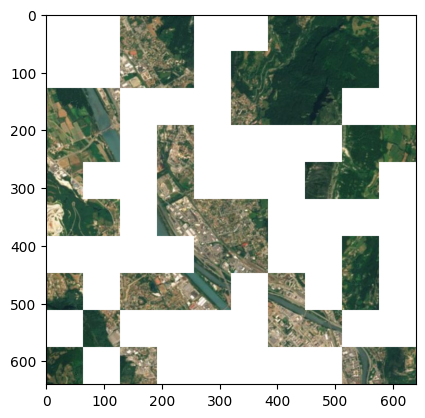

In [23]:
plt.imshow(img)

In [57]:
cat_pred1[0, 2]

6

In [58]:
cat_pred1[2, 0]

2

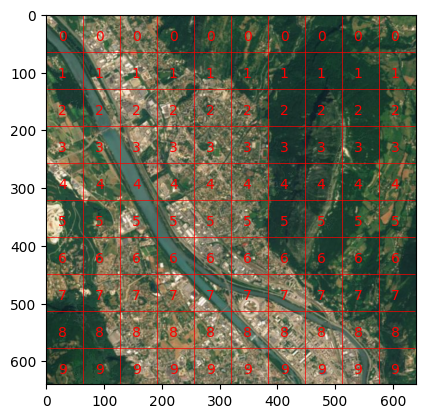

In [65]:
plot_image_categories(new_img1, cat_pred)

In [25]:
cat_pred = []
for i in range(10):
    arr = np.full((10), i)
    cat_pred.append(arr)

cat_pred = np.array(cat_pred)

In [64]:
cat_pred

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]])

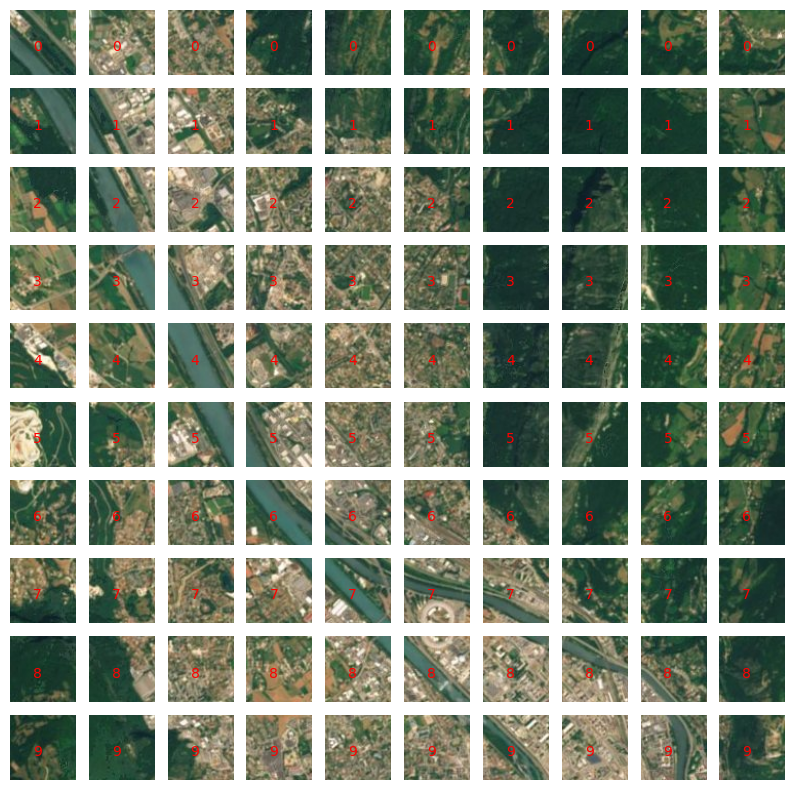

In [63]:
plot_sub_images_categories(new_img1, cat_pred)

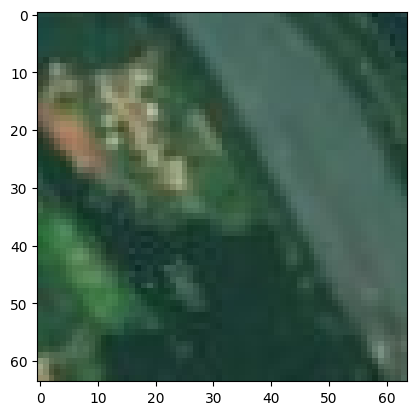

In [44]:
i = 10
plt.imshow(Image.fromarray(X_test1[i]))

In [45]:
cat_pred1.reshape(100).reshape((10,10))

array([[3, 4, 6, 5, 5, 2, 9, 9, 5, 2],
       [5, 4, 6, 4, 2, 5, 9, 1, 1, 0],
       [2, 2, 6, 6, 6, 2, 9, 1, 9, 2],
       [6, 2, 6, 6, 6, 6, 9, 5, 9, 0],
       [4, 0, 0, 6, 6, 6, 9, 8, 5, 0],
       [6, 2, 6, 4, 6, 6, 1, 5, 5, 0],
       [6, 6, 6, 0, 6, 6, 2, 5, 5, 5],
       [6, 6, 6, 6, 2, 6, 6, 2, 8, 9],
       [1, 2, 6, 6, 6, 6, 6, 6, 2, 9],
       [5, 9, 6, 6, 6, 6, 6, 6, 6, 2]])

In [41]:
cat_pred1

array([[3, 4, 6, 5, 5, 2, 9, 9, 5, 2],
       [5, 4, 6, 4, 2, 5, 9, 1, 1, 0],
       [2, 2, 6, 6, 6, 2, 9, 1, 9, 2],
       [6, 2, 6, 6, 6, 6, 9, 5, 9, 0],
       [4, 0, 0, 6, 6, 6, 9, 8, 5, 0],
       [6, 2, 6, 4, 6, 6, 1, 5, 5, 0],
       [6, 6, 6, 0, 6, 6, 2, 5, 5, 5],
       [6, 6, 6, 6, 2, 6, 6, 2, 8, 9],
       [1, 2, 6, 6, 6, 6, 6, 6, 2, 9],
       [5, 9, 6, 6, 6, 6, 6, 6, 6, 2]])